# Implementation of the SPT Model - Version 2

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 9th, 2022

In [1]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import emcee

In [2]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

In [3]:
import pandas as pd
import arviz as az
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pyl
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

In [6]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
display(data[:2])

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [7]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])
m500 = np.array(data['M500'])*1e14

In [8]:
ix = np.where(lambda_chisq>5)[0] # take 100 points
Np = ix.size

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

print('Npoints:',Np)

Npoints: 298


In [9]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmax(lambda_chisq[lambda_chisq>0])]

lbd_hat_i = lambda_chisq[ix]
lbd_err_i = lambda_chisqE[ix]
chisi_i = sz_signal[ix]
z_i = redshift[ix]
print(lbd_hat_i)
print(chisi_i)

203.78017
10.641013


In [10]:
# test function 
# debuging here
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [11]:
y = np.vstack([lbd_hat,chisi])
#print("This is y:", y)
yerr = lbd_err
#print("This is yerr:", yerr)
x = redshift
#print("This is x:", x)

In [12]:
np.max(np.log10(m500))

<ipython-input-12-c0309a2e430a>:1: RuntimeWarning: divide by zero encountered in log10
  np.max(np.log10(m500))


15.159748

In [13]:
# set up integration vectors
mvec = np.logspace(14.1, 15.25, 40)
lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
zetavec = np.linspace(1,1.1*np.max(sz_signal),75)

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
40
150
75


(array([17., 64., 75., 45., 27., 19., 16., 13.,  7.,  7.]),
 array([14.481873, 14.530734, 14.579596, 14.628457, 14.677319, 14.726179,
        14.775041, 14.823902, 14.872764, 14.921625, 14.970487],
       dtype=float32),
 <BarContainer object of 10 artists>)

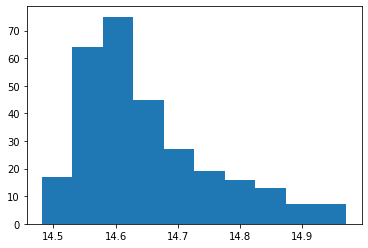

In [14]:
plt.hist(np.log10(data['M500'][lambda_chisq>20]*1e14))

In [15]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

In [16]:
zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [17]:
hmf_vector = halo_mass_function2(z).T
hmf_vector.shape

(298, 40)

In [18]:
def prob_chisi(zeta, chisi, eps=1e-12):
    res = np.exp(-(chisi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, lbd_hat, lbd_error, eps=1e-12):
    res = gaussian(lbd, lbd_hat, lbd_error)
    return res#np.where(res<eps,0.,res)

# taking only points with a significant p_chisi/lbd_hat
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [19]:
prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i) 
                             for lbd_hat_i, lbd_err_i in zip(lbd_hat, lbd_err)])
print(prob_lbd_hat_vec.shape)
print("This is prob_lbd_hat_vec:", prob_lbd_hat_vec)

prob_chisi_vec = np.array([prob_chisi(zetavec, chisi_i) for chisi_i in chisi])
print(prob_chisi_vec.shape)
print("This is prob_chisi_vec:", prob_chisi_vec)

alpha = 0.1

lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
print(lbd_indices_vec.shape)
#print("This is lbd_indices_vec:", lbd_indices_vec)

zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
print(zeta_indices_vec.shape)
#print("This is zeta_indices_vec:", zeta_indices_vec)

(298, 150)
This is prob_lbd_hat_vec: [[3.55835690e-069 1.39524610e-066 4.86580366e-064 ... 3.97767573e-234
  5.14151116e-239 5.91091399e-244]
 [3.31146659e-107 6.78547473e-104 1.23109203e-100 ... 1.55058854e-187
  5.40964096e-192 1.67105496e-196]
 [1.38276132e-041 8.87415617e-040 5.16950089e-038 ... 3.14778944e-227
  1.32683204e-231 5.07654134e-236]
 ...
 [4.77972074e-010 1.53668904e-008 3.51851816e-007 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.93965052e-033 7.01001735e-031 1.34940525e-028 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.94718665e-095 1.44331125e-091 3.03242860e-088 ... 2.65676745e-269
  4.02326831e-275 5.27456451e-281]]
(298, 75)
This is prob_chisi_vec: [[9.94323129e-006 2.65440715e-005 7.71882138e-005 ... 5.15202651e-083
  6.24541908e-086 6.72978097e-089]
 [3.12117363e-004 6.96282583e-004 1.64793429e-003 ... 4.30154918e-090
  3.93418730e-093 3.19842585e-096]
 [7.88253844e-004 1.66376314e-003 3.69548178e-003 ... 2.46542555e-092
  2.06726091e

# Likelihood

In [20]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)
Ez2 = interpolate.interp1d(zvec, E(zvec), kind='cubic')

#Insert the priors on the SZE scaling relation parameters that identify with SZE,
# along with a value for the mass (M) and redshift (z)
## References Equation 2 
M0 = 3e14
Ez0 = E(0)
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(Ez2(z)/Ez0))

#Insert the priors on the SZE scaling relation parameters that identify with LAMBDA, 
# along with a value for the mass (M) and redshift (z)
# Identified with the 
## References Equation 3
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(Ez2(z)/Ez0))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [21]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
        break
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [22]:
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    z_i = z[ix]
    #print("This is z_i:", z_i)
    p_chisi = prob_chisi_vec[ix]
    #print("This is p_chisi:", p_chisi)
    p_lbd_hat = prob_lbd_hat_vec[ix]
    #print("This is p_lbd_hat:", p_lbd_hat)
    llo, lup = list(lbd_indices_vec[ix])
    #print("This is the list of lbd_indices_vec[ix]:", lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    #print("This is the list of zeta_indices_vec[ix]:", zeta_indices_vec[ix])
    halo_mass_func = hmf_vector[ix]
    

    #print("This is llo:", llo)
    #print("This is lup:", lup)
    
    #print("This is clo:", clo)
    #print("This is cup:", cup)
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    #print("This is ln_lbd_pred before lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    #print("This is ln_zeta_pred before lup,llo,cup,clo:", ln_zeta_pred)
    
    hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    #print("This is ln_lbd_pred after lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    #print("This is ln_lbd_pred after lup,llo,cup,clo:", ln_zeta_pred)
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[:,clo:cup,llo:lup],zz[:,clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred, hmf)
    print("This is p_total_m:", p_total_m)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)
    #print("This is p_lbd_zeta:", p_lbd_zeta)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    #print("This is p_chisi:", p_chisi)
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    #print("This is p_lbd after trapezoidal transformation:", p_lbd)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    #print("This is p after trapezoidal transformation:", p)
    
    return p

In [30]:
def compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, hmf, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    print("This is ln_zeta_pred (1):", ln_zeta_pred)
    print("This is scatter_sze (2):", scatter_sze)
    print("This is s_zeta (3):", s_zeta)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    print("This is ln_lbd_pred (1):", ln_lbd_pred)
    print("This is scatter_lambda (2):", scatter_lambda)
    print("This is s_lambda (3):", s_lambda)
    s_zeta_inv = np.where(scatter_sze<=s_zeta, -np.inf, 1/s_zeta)
    print("This is s_zeta_inv:", s_zeta_inv)
    s_lambda_inv = np.where(s_lambda<=eps, -np.inf, 1/s_lambda)
    print("This is s_lambda_inv:", s_lambda_inv)
    
    cov = (scatter_lambda)**(2)*(scatter_sze)**(2)*(1-rho**2)
    print("This is cov matrix:", cov)
    additional_cov = (-0.5)*np.log(np.pi*cov**2)
    print("This is additional_cov:", additional_cov)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    print("This is rho_inv pt1:", rho_inv)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    print("This is rho_inv pt2:", rho_inv)
    
    # defining standardized variables
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda_inv
    print("This is lbd_std:", lbd_std)
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta_inv
    print("This is zeta_std:", zeta_std)
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2
    print("This is lp_lbd:", lp_lbd)

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2
    print("This is lp_zeta:", lp_zeta)

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    print("This is lp_corr:", lp_corr)

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    print("This is lp_total_m:", lp_total_m)
    
    p_total_m = (hmf*np.exp(lp_total_m))/(lvec*zvec)
    print("This is p_total_m:", p_total_m)
    
    return p_total_m

In [31]:
# Implementing the log_likelihood_vec2 in the emcee code
# via writing to the prior functions.

# In reference to rho's (ρ) defintion it states:
# Parameters of the richness–mass relation defined
# in Eq. 11 (Bleem et al. 2019) 
## and the correlation coefficient, ρSZ−λ, between the SZ signal (ζ) and richness.

# ρ also defined as the correlation coefficient  
# that encodes the degree of correlation between the intrinsic scatters on the respective observables

In [32]:
def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [33]:
logprior(theta)

0.0

In [34]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [35]:
Nburnin = 600 # number of burn-in samples
Nsamples = 1800 # number of final posterior samples
walkers = 100
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(z))#[:100]
sel = np.random.randint(len(z), size=100, dtype=int)
argslist = [sel]

In [36]:
logposterior(theta, sel)

This is ln_zeta_pred (1): [[[0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]
  [0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]
  [0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]
  ...
  [0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]
  [0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]
  [0.47318449 0.47318449 0.47318449 ... 0.47318449 0.47318449 0.47318449]]

 [[0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]
  [0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]
  [0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]
  ...
  [0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]
  [0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]
  [0.57733809 0.57733809 0.57733809 ... 0.57733809 0.57733809 0.57733809]]

 [[0.68149169 0.68149169 0.68149169 ... 0.68149169 0.68149169 0.681491

-inf

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.1 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

In [ ]:
theta

In [ ]:
soln.x[-1]

In [ ]:
import time
from multiprocessing import Pool
with Pool(processes = 16) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=argslist, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

In [ ]:
# set up the sampler
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required
sampler.run_mcmc(guess, Nsamples+Nburnin);

# extract the samples (removing the burn-in)
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [ ]:
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"Aλ", r"Bλ", r"Cλ", r"Scatter", r"A_SZE", r"B_SZE", r"C_SZE", r"Scatter_SZE", "ρ"]
                    , show_titles = True, truths=[A_lambda, B_lambda, C_lambda, scatter_lambda,
                                                  A_sze, B_sze, C_sze, scatter_sze, rho])

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

In [ ]:
import os

os.environ.keys()